In [1]:
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from BatchLayers.StatLayers import Mean, Variance

from CombineLayers.ElementWiseLayers import Add, Multiply, Power, Maximum

from CompoundLayers.SequentialLayer import Sequential
from CompoundLayers.SplitLayer import Split

from MutableLayers.MutableSplitLayers import MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit
from MutableLayers.MutableResizeLayers import MutableResizeFive, MutableResizeFifth

from OpLayers.AffineLayers import Linear, AddBias, LinearResize
from OpLayers.ScalarFuncLayers import Log, Exp, Identity, Abs, Sin, Reciprocal
from OpLayers.VectorFuncLayers import Pow, Scale

from SamplePopulation import NSGIISamplePopulation, NSGIIChainSamplePopulation, NSGIICompoundSamplePopulation

from SampleLayers.SampleSequentialLayer import SampleSequential
from SampleLayers.SampleSplitLayer import SampleSplit, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower
from SampleLayers.SampleResizeLayer import SampleResize, SampleResizeFive, SampleResizeFifth
from SampleLayers.SampleCompoundLayer import SampleCompound
from SampleLayers.SampleChainLayer import SampleChain

torch.set_printoptions(threshold=10000)

In [49]:
op_layers = [ Linear, AddBias, Sin, Pow, Exp, Identity ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower, SampleResizeFive, SampleResizeFifth]

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f = lambda x : torch.nn.functional.sigmoid(x)

x_train = torch.tensor(np.linspace(start=-20, stop=20, num=200).reshape((200, 1)), dtype=torch.float32, device=device)
y_train = f(x_train)

x_test = torch.tensor(np.random.uniform(-20, 20, size=(500, 1)), dtype=torch.float32, device=device)
y_test = f(x_test)

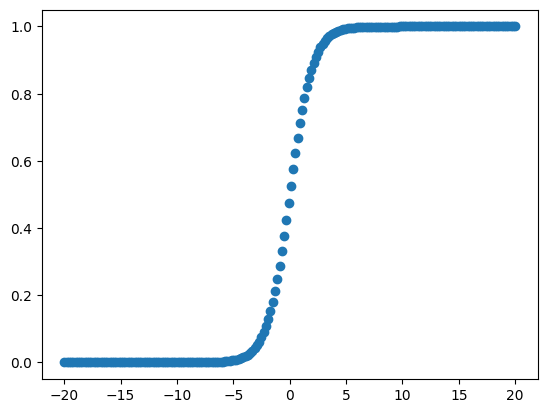

In [51]:
plt.plot(x_train.clone().detach().cpu().numpy(), y_train.clone().detach().cpu().numpy(), 'o')
plt.show()

In [54]:
n = 10000

max_depth = 6
chain_length = 1

num_layers = len(op_layers)
num_compound_layers = len(compound_layers)

dim = 1

fair_epochs = 500
batch_size = 32
runs = 50

k = 3

In [55]:
sample_chain = SampleChain(dim, dim * 5, dim, max_depth, op_layers, compound_layers, chain_length, shared=True, lr=0.01).to(device)
# sample_chain = SampleCompound(dim, dim * 5, max_depth, op_layers, compound_layers, lr=0.01).to(device)

sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)
# sample_chain_pop = NSGIICompoundSamplePopulation(sample_chain, n)

print(sample_chain_pop.gen_paths())

sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

tensor([[0, 0, 2, 3, 3, 5, 2, 1],
        [4, 2, 5, 5, 4, 2, 4, 1],
        [5, 5, 3, 1, 5, 1, 0, 2],
        [1, 1, 0, 4, 2, 3, 3, 3],
        [6, 4, 1, 0, 1, 4, 5, 3],
        [0, 3, 4, 2, 0, 0, 1, 3]])


Training: 100%|██████████| 500/500 [00:40<00:00, 12.42it/s]


Evaluating Pool: 100%|██████████| 10000/10000 [00:07<00:00, 1283.72it/s]


Supernet SampleChain(
  dim=1
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[-0.275651   -1.0295886   0.31384507 -0.848105   -0.14059606]
         [ 0.6008488   0.12912014 -1.3381801  -0.98324186  0.60241956]
         [-1.1274102  -0.07849648  0.88411856 -0.34894937  1.4431705 ]
         [ 0.36282295  0.79431075 -0.20008148 -0.13884033  0.14027396]
         [ 0.362299   -0.9852884   1.0049365   1.1107846  -0.4171438 ]]
      )
      (1): AddBias(dim=5, b=[-0.11403518  0.3180568   0.6815359  -0.7498261   0.8608786 ])
      (2): Sin(dim=5)
      (3): Pow(dim=5, exp=[ 0.10830134 -0.0888339   0.01165456 -0.02610107 -0.55616534])
      (4): Exp(dim=5)
      (5): Identity(dim=5)
    )
    (1): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[-0.10602548  0.92585933  0.9006478  -0.9078582  -1.2049099 ]
         [-0.30257884  0.31186837 -0.6112125  -0.72827303 -1.8998688 ]
         [ 0.20360863 -0.19486384  0.7736791   0.18659116  

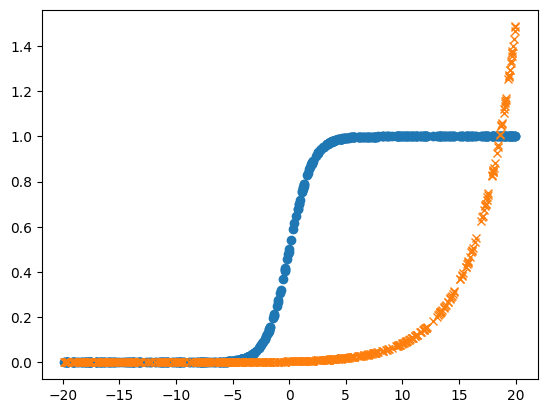

In [61]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path {sample_chain_pop.pool[min_idx]}")

min_path = sample_chain_pop.pool[min_idx]

plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.plot(x_test.clone().detach().cpu().numpy(), sample_chain_pop.supernet(min_path, x_test).clone().detach().cpu().numpy(), 'x')
plt.show()

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 327.17it/s]

Supernet SampleResizeFive(
  dim=1
  (first): LinearResize(
    in_dim=1, out_dim=5, A=[[ 1.0550547e+00 -1.2826350e+00  1.5522097e-01  2.0794460e-04
       1.7478169e+00]]
  )
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[ 1.4158713   0.5466741   0.05756081 -1.4089794  -0.05362822]
         [ 0.9923314   0.23819555  0.5797438   1.564257    1.4905394 ]
         [-0.68458295  1.9421961   0.43356898  1.006918   -1.0634228 ]
         [-1.6686314  -1.0120437  -1.0410881  -0.8669356   0.9732893 ]
         [ 1.6540612  -2.350858   -0.30990574  1.1213166   0.05466415]]
      )
      (1): AddBias(dim=5, b=[-0.35578066 -1.260779    1.9096398  -0.02382079 -0.05809028])
      (2): Sin(dim=5)
      (3): Pow(dim=5, exp=[ 1.7842104  -0.48118258 -0.00771303 -0.9120221  -0.7896034 ])
      (4): Exp(dim=5)
      (5): Identity(dim=5)
    )
    (1): ModuleList(
      (0): Linear(
        in_dim=5, out_dim=5, A=[[ 0.15888295 -0.560653    0.09022646  0.274033

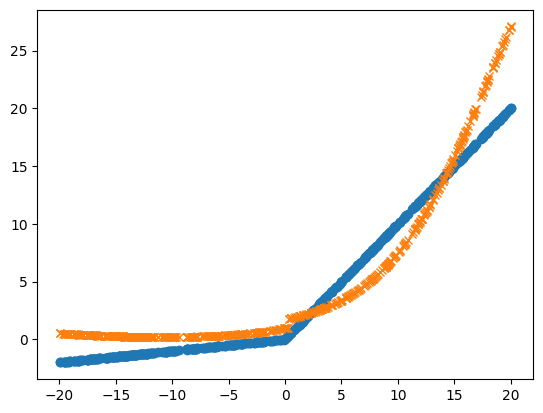

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 374.32it/s]


Supernet SampleSplitAdd(
  dim=1
  (combine): Add(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.0905647]])
      (1): AddBias(dim=1, b=[-1.9750241])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.18086566])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.07299856]])
      (1): AddBias(dim=1, b=[-0.30883396])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.28569874])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.04723741]])
      (1): AddBias(dim=1, b=[0.01094637])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.21093312])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.19154654]])
      (1): AddBias(dim=1, b=[-1.7776457])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.07337429])
 

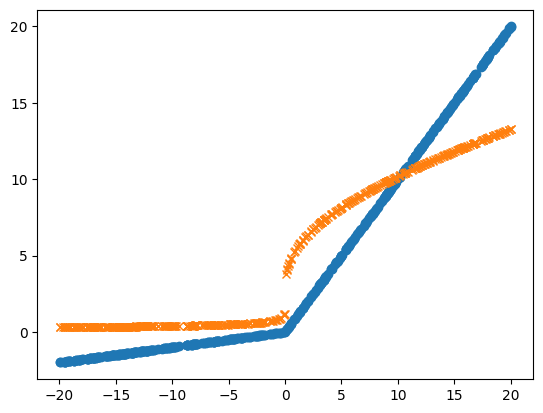

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 288.83it/s]

Supernet SampleSplitMaximum(
  dim=1
  (combine): Maximum(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.32574788]])
      (1): AddBias(dim=1, b=[-3.607631])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.36611596])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.14990076]])
      (1): AddBias(dim=1, b=[-1.9718353])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.4336936])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.05874797]])
      (1): AddBias(dim=1, b=[-2.2666562])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.5058397])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.45335633]])
      (1): AddBias(dim=1, b=[-3.7369342])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.1890430

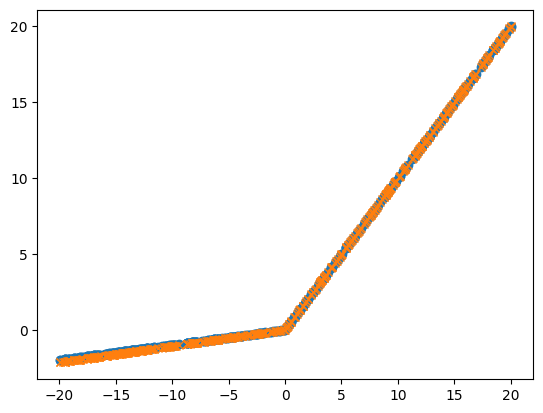

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 340.55it/s]


Supernet SampleSplitMultiply(
  dim=1
  (combine): Multiply(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.02950027]])
      (1): AddBias(dim=1, b=[-1.6891501])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-0.3730411])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.00157309]])
      (1): AddBias(dim=1, b=[-0.48847014])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.154657])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[-0.00617266]])
      (1): AddBias(dim=1, b=[-0.04245858])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.22656111])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.09387072]])
      (1): AddBias(dim=1, b=[0.05848172])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-0.

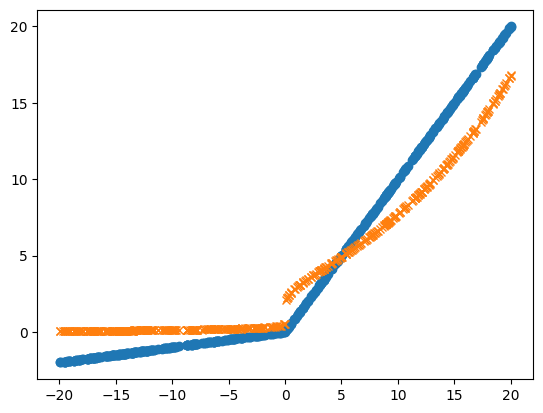

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 332.84it/s]


Supernet SampleSplitPower(
  dim=1
  (combine): Power(dim=1)
  (left): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.17224911]])
      (1): AddBias(dim=1, b=[0.99215573])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.00911453])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.18582009]])
      (1): AddBias(dim=1, b=[-0.5854355])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.31558216])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.73725337]])
      (1): AddBias(dim=1, b=[0.3886053])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.10503445])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
  )
  (right): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[-0.1451547]])
      (1): AddBias(dim=1, b=[0.7498062])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[-1.3028474])

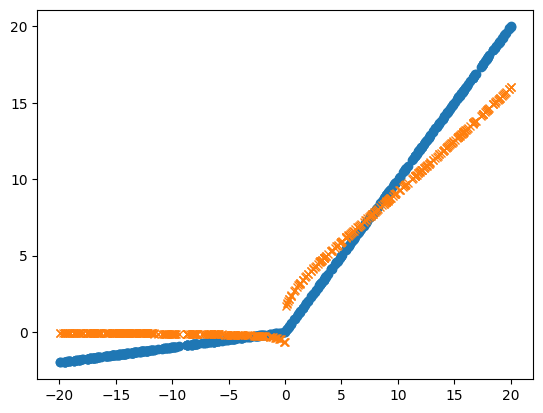

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 323.14it/s]


Supernet SampleSequential(
  dim=1
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.5703065]])
      (1): AddBias(dim=1, b=[-1.9746394])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.21648212])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (1): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.43637413]])
      (1): AddBias(dim=1, b=[-1.1958089])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.31796926])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (2): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.09650247]])
      (1): AddBias(dim=1, b=[-1.1657952])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.48776895])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
    )
    (3): ModuleList(
      (0): Linear(in_dim=1, out_dim=1, A=[[0.08223934]])
      (1): AddBias(dim=1, b=[-0.935465])
      (2): Sin(dim=1)
      (3): Pow(dim=1, exp=[0.49030894])
      (4): Exp(dim=1)
      (5): Identity(dim=1)
   

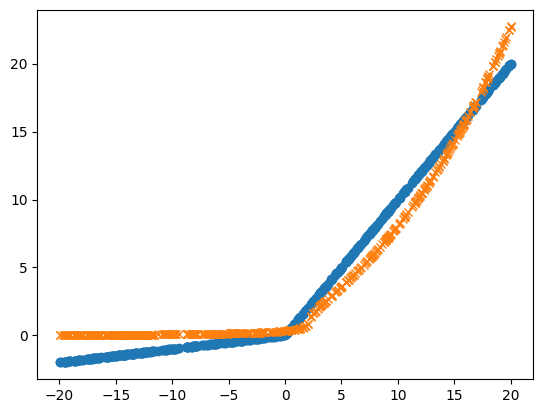

[tensor(4.3991), tensor(6.9388), tensor(0.0048), tensor(3.9106), tensor(2.6043), tensor(1.8005)]
[tensor(50.5478), tensor(28.7237), tensor(12.2869), tensor(45.3955), tensor(44.1330), tensor(41.6342)]


In [8]:
segments = torch.nn.ModuleList([ SampleResizeFive(dim, max_depth, op_layers, lr=0.01), SampleSplitAdd(dim, max_depth, op_layers, lr=0.01), SampleSplitMaximum(dim, max_depth, op_layers, lr=0.01), SampleSplitMultiply(dim, max_depth, op_layers, lr=0.01), SampleSplitPower(dim, max_depth, op_layers, lr=0.01), SampleSequential(dim, max_depth, op_layers, lr=0.01) ])
segments.to(device)

min_path = []
min_acc = []
avg_acc = []

for segment in segments:
    population = NSGIISamplePopulation(segment, n, torch.randint(0, num_layers, (n, max_depth)))
    population.train_fair_dataset(x_train, y_train, epochs=fair_epochs, batch_size=batch_size)
    population.evaluate_pool_dataset(x_test, y_test)

    for _ in range(3):
        population.gen_children(k=k)
        population.evaluate_children_dataset(x_test, y_test)

        population.step(percentile=0.75)

    min_acc.append(torch.min(population.stats[:, 0]))
    avg_acc.append(torch.mean(population.stats[:, 0]))

    print(f"Supernet {population.supernet.cpu()}")
    population.supernet.to(device)

    print(f"Pool {population.pool}")
    print(f"Stats {population.stats}")

    plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
    plt.plot(x_test.clone().detach().cpu().numpy(), population.supernet(population.pool[0], x_test).clone().detach().cpu().numpy(), 'x')
    plt.show()

print(min_acc)
print(avg_acc)

In [11]:
data = pd.read_csv("data/StudentPerformance/data.csv")

predictors = data.drop(columns=["StudentID", "GPA", "GradeClass"], axis=1)
targets = data["GPA"]

train_ratio = 0.8
split = torch.randperm(len(predictors))

train_split = split[:int(train_ratio * len(data))]
test_split = split[int(train_ratio * len(data)):]

device = torch.device("cuda")

x_train = torch.tensor(predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [33]:
n = 10000
k = 3

max_depth = 6
dim = len(predictors.columns)
chain_length = 1

batch_size = 32
fair_epochs = 500

In [34]:
op_layers = [ Linear, AddBias, Sin, Pow, Exp, Identity ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower, SampleResizeFive, SampleResizeFifth]

In [35]:
sample_chain = SampleChain(dim, dim * 5, 1, max_depth, op_layers, compound_layers, chain_length, lr=0.01).to(device)

sample_chain_pop = NSGIIChainSamplePopulation(sample_chain, n)
sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)

Training: 100%|██████████| 500/500 [05:23<00:00,  1.55it/s]


In [41]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

# print(f"Pool {sample_chain_pop.pool}")
# print(f"Stats {sample_chain_pop.stats}")

min_idx = torch.argmin(torch.nan_to_num(sample_chain_pop.stats[:, 0], nan=torch.inf))
print(f"Min {sample_chain_pop.stats[min_idx]}")
print(f"Min Path {sample_chain_pop.pool[min_idx]}")

min_path = sample_chain_pop.pool[min_idx]

Evaluating Pool: 100%|██████████| 10000/10000 [00:08<00:00, 1244.57it/s]


Supernet SampleChain(
  dim=12
  (chain): ModuleList(
    (0): SampleCompound(
      dim=12
      (grid): ModuleList(
        (0): ModuleList(
          (0): Linear(
            in_dim=60, out_dim=60, A=[[-0.21389204  0.37478217  1.8861568  ... -0.52882606 -0.28007898
              -0.58623064]
             [-1.7382284  -0.9299744  -0.14636476 ... -1.9051323   0.4722816
              -1.0129222 ]
             [-0.00285877 -1.8722864   0.19132988 ... -0.8977324   0.46829906
               1.0423131 ]
             ...
             [-0.4662442  -1.011246   -1.0826149  ... -1.3714204  -1.1567618
               0.05906386]
             [ 1.4515749  -0.3638623   1.3423976  ...  0.83052707 -0.5050043
               0.1014859 ]
             [-0.32695693  0.1173021   1.3577945  ... -0.6581676   0.28106114
              -0.52126396]]
          )
          (1): AddBias(
            dim=60, b=[ 1.2639073   0.5623966  -1.9409313   0.18928334  0.79948044  2.004295
             -1.3992591   0.2610646

In [46]:
sample_chain.train_dataset(x_train, y_train, fair_epochs, batch_size, min_path)

Training: 100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


In [47]:
print(sample_chain.evaluate_dataset(x_train, y_train, min_path))
print(sample_chain.evaluate_dataset(x_test, y_test, min_path))

0.04113409295678139
0.04051985964179039


In [3]:
train_data = pd.read_csv("data/ConcreteStrength/train.csv")
val_data = pd.read_csv("data/ConcreteStrength/test.csv")

train_predictors = train_data.drop(["id", "Strength"], axis=1)
val_predictors = val_data.drop(["id"], axis=1)

train_targets = train_data["Strength"]

train_ratio = 0.8
split = torch.randperm(len(train_predictors))

train_split = split[:int(train_ratio * len(train_predictors))]
test_split = split[int(train_ratio * len(train_predictors)):]

device = torch.device("cuda")

x_train = torch.tensor(train_predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(train_targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(train_predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(train_targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [11]:
n = 300
k = 3

max_depth = 10
dim = len(train_predictors.columns)

batch_size = 32
fair_epochs = 500

In [12]:
op_layers = [ Linear, AddBias, Sin, Pow, Exp, Identity ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

compound_layers = [ SampleSequential, SampleSplitAdd, SampleSplitMaximum, SampleSplitMultiply, SampleSplitPower, SampleResizeFive, SampleResizeFifth]

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 377.29it/s]


Supernet SampleCompound(
  dim=8
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=40, out_dim=40, A=[[-1.736732    0.24041614 -0.6038291  ...  0.07836987  1.0459124
          -1.6706114 ]
         [-0.73779404  1.8633033  -1.0392168  ...  0.4264931  -0.22033073
           0.8443813 ]
         [-0.39779317  0.8934525   0.3940771  ...  0.44248313  0.92032826
           1.3678863 ]
         ...
         [ 1.139905    0.3593172  -1.2254776  ... -0.04648943  0.00419153
          -0.29872304]
         [ 0.7181586  -0.06939237  0.44398263 ...  1.5575097  -1.624831
          -0.68823767]
         [ 3.22327     0.1700702  -0.51046246 ... -0.6558473   0.65828806
          -0.1072017 ]]
      )
      (1): AddBias(
        dim=40, b=[-0.2802934  -1.7470363  -0.8504019   0.4317633   1.8967633  -2.2026958
          1.4596804   0.18107824  0.3122856   0.1549239  -0.7865542   0.39943665
         -0.4224613  -0.28734955  1.0076481  -1.3356377   1.9757595   2.4996607
        

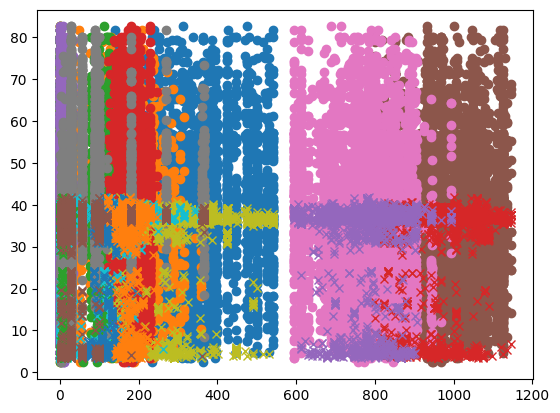

In [13]:
sample_chain = SampleCompound(dim, dim * 5, 1, max_depth, op_layers, compound_layers, lr=0.01, loss_fn=lambda x, y : torch.sqrt(torch.nn.functional.mse_loss(x, y))).to(device)

sample_chain_pop = NSGIICompoundSamplePopulation(sample_chain, n)
sample_chain_pop.initialize_randomly()

sample_chain_pop.train_fair_dataset(x_train, y_train, fair_epochs, batch_size)
sample_chain_pop.evaluate_pool_dataset(x_test, y_test)

for _ in range(3):
    sample_chain_pop.gen_children(k=k)
    sample_chain_pop.evaluate_children_dataset(x_test, y_test)

    sample_chain_pop.step(percentile=0.75)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

print(f"Pool {sample_chain_pop.pool}")
print(f"Stats {sample_chain_pop.stats}")

In [14]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_train, y_train)

for _ in range(3):
    sample_chain_pop.gen_children(k=k)
    sample_chain_pop.evaluate_children_dataset(x_train, y_train)

    sample_chain_pop.step(percentile=0.75)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

print(f"Pool {sample_chain_pop.pool}")
print(f"Stats {sample_chain_pop.stats}")

Computing fronts: 100%|██████████| 450/450 [00:00<00:00, 494.54it/s]


Supernet SampleCompound(
  dim=8
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=40, out_dim=40, A=[[-1.736732    0.24041614 -0.6038291  ...  0.07836987  1.0459124
          -1.6706114 ]
         [-0.73779404  1.8633033  -1.0392168  ...  0.4264931  -0.22033073
           0.8443813 ]
         [-0.39779317  0.8934525   0.3940771  ...  0.44248313  0.92032826
           1.3678863 ]
         ...
         [ 1.139905    0.3593172  -1.2254776  ... -0.04648943  0.00419153
          -0.29872304]
         [ 0.7181586  -0.06939237  0.44398263 ...  1.5575097  -1.624831
          -0.68823767]
         [ 3.22327     0.1700702  -0.51046246 ... -0.6558473   0.65828806
          -0.1072017 ]]
      )
      (1): AddBias(
        dim=40, b=[-0.2802934  -1.7470363  -0.8504019   0.4317633   1.8967633  -2.2026958
          1.4596804   0.18107824  0.3122856   0.1549239  -0.7865542   0.39943665
         -0.4224613  -0.28734955  1.0076481  -1.3356377   1.9757595   2.4996607
        

In [18]:
sample_chain.train_dataset(sample_chain_pop.pool[0], x_train, y_train, fair_epochs, batch_size)
sample_chain.evaluate_dataset(sample_chain_pop.pool[0], x_train, y_train)

Training: 100%|██████████| 500/500 [04:17<00:00,  1.94it/s]


16.213375091552734

In [17]:
sample_chain_pop.initialize_randomly()
sample_chain_pop.evaluate_pool_dataset(x_train, y_train)

for _ in range(3):
    sample_chain_pop.gen_children(k=k)
    sample_chain_pop.evaluate_children_dataset(x_train, y_train)

    sample_chain_pop.step(percentile=0.75)

print(f"Supernet {sample_chain_pop.supernet.cpu()}")
sample_chain_pop.supernet.to(device)

print(f"Pool {sample_chain_pop.pool}")
print(f"Stats {sample_chain_pop.stats}")

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 401.91it/s]


Supernet SampleCompound(
  dim=8
  (grid): ModuleList(
    (0): ModuleList(
      (0): Linear(
        in_dim=40, out_dim=40, A=[[ 2.7100724e-01 -8.5022777e-01 -1.4183438e+00 ...  1.6732733e-05
           2.2331372e-04 -3.5669366e-04]
         [-1.6773240e-01  9.6641898e-02 -8.8617307e-01 ...  9.1060632e-05
          -4.7043151e-05  1.8028459e-04]
         [ 3.7728345e-01 -8.2104467e-02 -1.9473861e+00 ...  9.4474730e-05
           1.9650052e-04  2.9205999e-04]
         ...
         [ 2.4338183e-04  7.6718381e-05 -2.6165319e-04 ... -9.9259678e-06
           8.9493943e-07 -6.3780491e-05]
         [ 1.5333523e-04 -1.4816037e-05  9.4795534e-05 ...  3.3254613e-04
          -3.4692069e-04 -1.4694696e-04]
         [ 6.8820565e-04  3.6311580e-05 -1.0898981e-04 ... -1.4003116e-04
           1.4055175e-04 -2.2888587e-05]]
      )
      (1): AddBias(
        dim=40, b=[-0.2802934  -1.7470363  -0.8504019   0.4317633   1.8967633  -2.2026958
          1.4596804   0.18107824  0.3122856   0.1549239  -